In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import madmom
import mir_eval
from modules.analysis_funcs import aubio_peakpicker_do, aubio_postprocessing
from analyze_detection import evaluate

from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt


In [9]:
from datasets import Dataset
ds0 = Dataset("initslurtest")
ds1 = Dataset("slurtest_add_1")

audio_fnames = ds0.get_audio_paths() + ds1.get_audio_paths()
label_fnames = ds0.get_annotation_paths() + ds1.get_annotation_paths()
audios = [madmom.audio.signal.load_wave_file(filename)[0] for filename in audio_fnames]
sample_rates = [madmom.audio.signal.load_wave_file(filename)[1] for filename in audio_fnames]
onset_schedules = [np.loadtxt(label_fname, usecols=0) for label_fname in label_fnames]

/usr/local/lib/python3.9/site-packages/madmom/audio/signal.py:457: UserWarning: Deprecated as of version 0.16. Please use madmom.io.audio.load_wave_file instead. Will be removed in version 0.18.
  warnings.warn('Deprecated as of version 0.16. Please use madmom.io.audio.'
/usr/local/lib/python3.9/site-packages/madmom/io/audio.py:493: WavFileWarning: Chunk (non-data) not understood, skipping it.
  file_sample_rate, signal = wavfile.read(filename, mmap=True)


In [26]:
sigg = madmom.audio.signal.SignalProcessor(num_channels=1)
frame = madmom.audio.signal.FramedSignalProcessor(frame_size=1024, hop_size=441)
stft = madmom.audio.stft.STFTProcessor()
proc = madmom.processors.SequentialProcessor([sigg, frame, stft])

In [27]:
SHIFT = 5
THRES = 0.15
TOL = 0.025
HOP = 441



In [23]:
THRESS = [0.001,0.01,0.05,0.1,0.15,0.2,0.5,0.9]
cds = np.zeros((len(THRESS), len(audio_fnames)))
fps = np.zeros((len(THRESS), len(audio_fnames)))
fns = np.zeros((len(THRESS), len(audio_fnames)))
tns = np.zeros((len(THRESS), len(audio_fnames)))

In [17]:
positives = np.zeros(len(audios))
negatives = np.zeros(len(audios))
for a, onsets in enumerate(onset_schedules):
    positives[a] = np.sum(onsets)
    negatives[a] = len(onsets) - np.sum(onsets)
    

In [28]:
for a, (fname, audio, onsets, sr) in enumerate(zip(audio_fnames, audios, onset_schedules, sample_rates)):
    
    for t, THRES in enumerate(THRESS):
        spect = proc(fname)
        hfc = madmom.features.onsets.high_frequency_content(np.abs(spect))
        onehot, out = aubio_peakpicker_do(hfc, threshold=THRES)
        peaks = (np.where(onehot==1)[0]-SHIFT)*HOP/sr
        [CD,FN,FP,doubles,merged] = evaluate(onsets, peaks, tol_sec=TOL)
        cds[t, a] = CD
        fps[t, a] = FP
        fns[t, a] = FN
        tns[t, a] = (len(onehot)-onehot.sum()) - FN
    print(fname)
    print(cds[:,a]/(cds[:,a]+0.5*fps[:,a]+fns[:,a]))


datasets/initslurtest_vn/initslurtest_vn_wav/slurtest01.wav
[0.42033898 0.43971631 0.52863436 0.64864865 0.75159236 0.7862069
 0.46153846 0.07874016]
datasets/initslurtest_vn/initslurtest_vn_wav/slurtest02.wav
[0.41696113 0.43703704 0.5462963  0.65909091 0.7037037  0.73333333
 0.544      0.1300813 ]
datasets/initslurtest_vn/initslurtest_vn_wav/slurtest03.wav
[0.42553191 0.44280443 0.55299539 0.65217391 0.72392638 0.73076923
 0.43076923 0.09677419]
datasets/initslurtest_vn/initslurtest_vn_wav/slurtest04.wav
[0.54744526 0.57034221 0.65777778 0.76041667 0.79545455 0.80239521
 0.36601307 0.10526316]
datasets/initslurtest_vn/initslurtest_vn_wav/slurtest05.wav
[0.36812144 0.38645418 0.46568627 0.5497076  0.64111498 0.6741573
 0.65420561 0.21463415]
datasets/initslurtest_vn/initslurtest_vn_wav/slurtest06.wav
[0.66465257 0.67484663 0.71317829 0.70906949 0.68203883 0.63840399
 0.37569061 0.10496454]
datasets/initslurtest_vn/initslurtest_vn_wav/slurtest07.wav
[0.64886251 0.66869919 0.69146608 0.

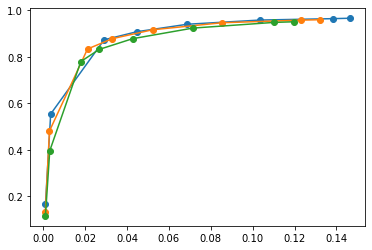

In [30]:
for win_size in [256, 512, 1024]:
    cds = np.load("results/hfc-eval-220422/hfc_AB_w"+ str(win_size)+"_tuning_cds.npy")
    fns = np.load("results/hfc-eval-220422/hfc_AB_w"+ str(win_size)+"_tuning_fns.npy")
    fps = np.load("results/hfc-eval-220422/hfc_AB_w"+ str(win_size)+"_tuning_fps.npy")
    tpr = cds.sum(1)/(cds.sum(1)+fns.sum(1))
    fpr = fps.sum(1)/(fps.sum(1)+tns.sum(1))
    fscores = cds.sum(1)/(cds.sum(1)+0.5*fps.sum(1)+0.5*fns.sum(1))
    plt.plot(fpr, tpr, '-o')
plt.show()


In [5]:
fscores

NameError: name 'tns' is not defined

In [29]:
np.save(file="results/hfc-eval-220422/hfc_AB_w1024_tuning_tns.npy", arr=tns)

In [ ]:
np.load(file="results/hfc-eval-220422/hfc_AB_w512_tuning_tns.npy")